In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization 
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
# Import stock data
df = pd.read_csv('../data/upload_DJIA_table.csv', parse_dates=['Date'], index_col='Date')
df = df[['Close']]
df = df.sort_index()

training_data_len = math.ceil(len(df) * .8)
training_data_len

train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)


(1592, 1) (397, 1)


In [4]:
bert_embeddings = np.load('../bert_embeddings.npy')

bert_train = bert_embeddings[:training_data_len]
bert_test = bert_embeddings[training_data_len:]
print(bert_train.shape, bert_test.shape)

(1592, 1, 768) (397, 1, 768)


In [8]:
# Selecting Open Price values
dataset_train = train_data.values
dataset_test = test_data.values

dataset_train.shape, dataset_test.shape

((1592, 1), (397, 1))

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)

print(scaled_train[:5])
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5]) #prints the first 5 rows of scaled_test


[[0.45640217]
 [0.46062803]
 [0.44832069]
 [0.43868547]
 [0.44598557]]
[0.84454818] [0.86667668] [0.82659367] [0.80725839] [0.70619221]


In [10]:
class LSTMModel(nn.Module):
	# input_size : number of features in input at each time step
	# hidden_size : Number of LSTM units 
	# num_layers : number of LSTM layers 
	def __init__(self, input_size, hidden_size, num_layers): 
		super(LSTMModel, self).__init__() #initializes the parent class nn.Module
		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
		self.linear = nn.Linear(hidden_size, 1)

	def forward(self, x): # defines forward pass of the neural network
		out, _ = self.lstm(x)
		out = self.linear(out)
		return out


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [12]:
input_size = 768
num_layers = 2
hidden_size = 64
output_size = 1

# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)


LSTMModel(
  (lstm): LSTM(768, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [13]:
# Create sequences and labels for training data

X_train, y_train = bert_train, scaled_train
X_test, y_test = bert_test, scaled_test

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).float()
y_train = torch.tensor(y_train, dtype=torch.float32).float()

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_test.shape, y_test.shape

(torch.Size([397, 1, 768]), torch.Size([397, 1]))

In [14]:
from torch.utils.data import TensorDataset, DataLoader


batch_size = 16
# Create DataLoader for batch training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for batch training
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [15]:
num_epochs = 50
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
	total_loss = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()

	# Calculate average training loss and accuracy
	average_loss = total_loss / len(train_loader)
	train_hist.append(average_loss)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_test_loss = 0.0

		for batch_X_test, batch_y_test in test_loader:
			batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
			predictions_test = model(batch_X_test)
			test_loss = loss_fn(predictions_test, batch_y_test)

			total_test_loss += test_loss.item()

		# Calculate average test loss and accuracy
		average_test_loss = total_test_loss / len(test_loader)
		test_hist.append(average_test_loss)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


/Users/baga_nuhkadiev/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/baga_nuhkadiev/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/baga_nuhkadiev/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([13, 1])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect result

Epoch [10/50] - Training Loss: 0.0565, Test Loss: 0.0915
Epoch [20/50] - Training Loss: 0.0562, Test Loss: 0.0705
Epoch [30/50] - Training Loss: 0.0563, Test Loss: 0.0817
Epoch [40/50] - Training Loss: 0.0562, Test Loss: 0.0948
Epoch [50/50] - Training Loss: 0.0562, Test Loss: 0.0780


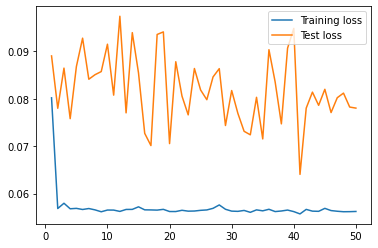

In [16]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()


In [21]:
### Lets Do the prediction and check performance metrics
with torch.no_grad():
    train_predict=model(X_train)
    test_predict=model(X_test)


In [22]:
train_predict = train_predict.squeeze()
test_predict = test_predict.squeeze()

In [23]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict=scaler.inverse_transform(test_predict.reshape(-1, 1))

In [30]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error

### Calculate RMSE performance metrics
t = scaler.inverse_transform(y_train)
math.sqrt(mean_squared_error(t,train_predict))

622.6200037110209

In [31]:
tt = scaler.inverse_transform(y_test)
math.sqrt(mean_squared_error(tt,test_predict))

741.4623210266183

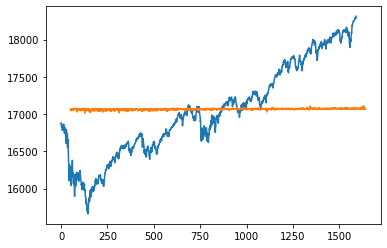

In [38]:
### Plotting
look_back=50
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict[:, -1].reshape(-1, 1)


plt.plot(t[:, 0])
plt.plot(trainPredictPlot)

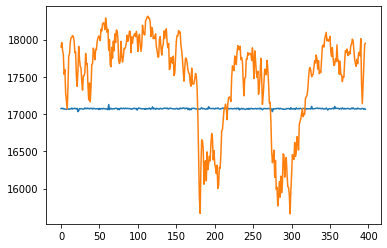

In [39]:
plt.plot(test_predict[:, -1])
plt.plot(tt[:, -1])
plt.show()